In [1]:
import torch
import torchvision
from torch.utils.data import Dataset
import h5py
import numpy as np
import os.path as osp
import pickle

import six

/home/purewhite/anaconda3/envs/default/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
# Dataloader Probe

In [2]:
from dataset.dataset import SketchDataset

trainSet = SketchDataset(
    mode='valid',
    data_seq_dir='/home/purewhite/workspace/cs420/project/data/dataset_raw',
    data_img_dir='/home/purewhite/workspace/cs420/project/data/dataset_processed_28',
    categories=['bear', 'cat', 'crocodile', 'elephant'],
    paddingLength=150,
    random_scale_factor=0.2,
    augment_stroke_prob=0.05,
    img_scale_ratio=0.5,
    img_rotate_angle=15,
    img_translate_dist=5
)

[*] Loaded 2500 valid sequences from bear.npz
[*] Loaded 2500 valid images from bear.npz
[*] Loaded 2500 valid sequences from cat.npz
[*] Loaded 2500 valid images from cat.npz
[*] Loaded 2500 valid sequences from crocodile.npz
[*] Loaded 2500 valid images from crocodile.npz
[*] Loaded 2500 valid sequences from elephant.npz
[*] Loaded 2500 valid images from elephant.npz


In [3]:
sample = trainSet[0]

In [4]:
print(len(sample))
strokes_5d, img, label = sample
print(strokes_5d.shape, img.shape, label)

3
(150, 5) (1, 28, 28) 0


In [5]:
from torch.utils.data import DataLoader

trainLoader = DataLoader(trainSet, batch_size=4, shuffle=True, pin_memory=True)

In [6]:
from tqdm import tqdm

loop = tqdm(trainLoader)
for i, batch in enumerate(loop):
    strokes, imgs, labels = batch
    print(strokes.shape, imgs.shape, labels)
    if (i > 5):
        break

  0%|          | 6/2500 [00:00<00:35, 70.04it/s]

torch.Size([4, 150, 5]) torch.Size([4, 1, 28, 28]) tensor([1, 0, 1, 1])
torch.Size([4, 150, 5]) torch.Size([4, 1, 28, 28]) tensor([1, 2, 3, 0])
torch.Size([4, 150, 5]) torch.Size([4, 1, 28, 28]) tensor([0, 3, 0, 2])
torch.Size([4, 150, 5]) torch.Size([4, 1, 28, 28]) tensor([0, 2, 3, 0])
torch.Size([4, 150, 5]) torch.Size([4, 1, 28, 28]) tensor([1, 1, 3, 2])
torch.Size([4, 150, 5]) torch.Size([4, 1, 28, 28]) tensor([0, 1, 1, 3])
torch.Size([4, 150, 5]) torch.Size([4, 1, 28, 28]) tensor([1, 0, 2, 2])


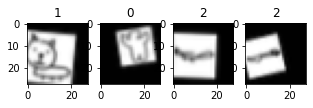

In [7]:
from matplotlib import pyplot as plt

plt.figure(figsize=(5, 20))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(imgs[i][0].cpu().numpy(), cmap='binary_r')
    plt.title(f'{labels[i]}')

---
# EfficientNet Probe

In [21]:
cnn = torchvision.models.efficientnet_b0(pretrained=True)

In [29]:
print(cnn.features)

for name, module in cnn.features.named_children():
    if (name == '0'):
        for c_name, c_module in module.named_children():
            print(c_name)

Sequential(
  (0): ConvNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): ConvNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=F

In [60]:
from collections import OrderedDict
import torch.nn as nn

def construct(in_channels):
    cnn = torchvision.models.efficientnet_b0(pretrained=True)

    if in_channels in [1, 3]:
        features = cnn.features
        print('[*] EfficientNetB0Backbone: use pretrained conv0 with {} input channels'.format(
            features[0][0].in_channels))
    else:
        from collections import OrderedDict
        print('[*] EfficientNetB0Backbone: cnn.features -', cnn.features.__class__.__name__)
        module_dict = OrderedDict()
        for name, module in cnn.features.named_children():
            if name == '0':
                print('name == 0')
                submodule0_dict = OrderedDict()
                for subname, submodule in module.named_children():
                    if (subname == '0'):
                        print('subname == 0')
                        # Original EfficientNetB0:
                        # Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
                        submodule0_dict[subname + '_new'] = nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=submodule.out_channels,
                            kernel_size=submodule.kernel_size,
                            stride=submodule.stride,
                            padding=submodule.padding,
                            bias=False
                        )
                    else:
                        submodule0_dict[subname] = submodule
                module_dict[name + '_new'] = nn.Sequential(submodule0_dict)
            else:
                module_dict[name] = module
        features = nn.Sequential(module_dict)
        print('[*] EfficientNetB0Backbone: use a new 0-0 with {} input channels'.format(in_channels))
    return features, cnn.avgpool, cnn.classifier

In [63]:
net_1 = construct(1)
print()
net_2 = construct(2)
print()
net_3 = construct(3)
print()
net_4 = construct(4)

[*] EfficientNetB0Backbone: use pretrained conv0 with 3 input channels

[*] EfficientNetB0Backbone: cnn.features - Sequential
name == 0
subname == 0
[*] EfficientNetB0Backbone: use a new 0-0 with 2 input channels

[*] EfficientNetB0Backbone: use pretrained conv0 with 3 input channels

[*] EfficientNetB0Backbone: cnn.features - Sequential
name == 0
subname == 0
[*] EfficientNetB0Backbone: use a new 0-0 with 4 input channels


In [75]:
# out1 = net_1(imgs.repeat(1, 3, 1, 1).float())
# out2 = net_2(imgs.repeat(1, 2, 1, 1).float())
# out3 = net_3(imgs.repeat(1, 3, 1, 1).float())
# out4 = net_4(imgs.repeat(1, 4, 1, 1).float())
# print(out1.shape, out2.shape, out3.shape, out4.shape)

out2 = net_2[0](imgs.repeat(1, 2, 1, 1).float())
print(out2.shape)
out2 = net_2[1](out2)
out2 = out2.reshape(out2.shape[:2])
print(out2.shape)
out2 = net_2[2](out2)
print(out2.shape)

torch.Size([4, 1280, 1, 1])
torch.Size([4, 1280])
torch.Size([4, 1000])


In [69]:
print(imgs.shape, imgs.dtype)
# images = imgs.float()
images = imgs.repeat(1, 3, 1, 1).float()
print(images.shape, images.dtype)

torch.Size([4, 1, 28, 28]) torch.uint8
torch.Size([4, 3, 28, 28]) torch.float32


In [76]:
print(images.shape, cnn(images).shape)

out = cnn.features(images)
print(out.shape)
out = cnn.avgpool(out)
out = out.reshape(out.shape[:2])
print(out.shape)
out = cnn.classifier(out)
print(out.shape)

torch.Size([4, 3, 28, 28]) torch.Size([4, 1000])
torch.Size([4, 1280, 1, 1])
torch.Size([4, 1280])
torch.Size([4, 1000])


In [59]:
for name, module in cnn.named_children():
    print(name)
    if (name != 'features'):
        print(module)

features
avgpool
AdaptiveAvgPool2d(output_size=1)
classifier
Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


In [81]:
print(cnn.classifier[1].in_features)

1280


---
# Feat Probe

In [4]:
data_seq = np.load('/home/purewhite/workspace/cs420/project/data/dataset_raw/bear.npz', mmap_mode='r', encoding='latin1', allow_pickle=True)
print(list(data_seq.keys()))
for k, v in data_seq.items():
    print(v.shape, [v[i].shape for i in range(3)])

['test', 'train', 'valid']
(2500,) [(86, 3), (61, 3), (111, 3)]
(70000,) [(47, 3), (65, 3), (114, 3)]
(2500,) [(42, 3), (74, 3), (92, 3)]


In [5]:
print(type(data_seq))

<class 'numpy.lib.npyio.NpzFile'>


In [6]:
print(data_seq['train'][0])

[[ 43   0   0]
 [  8   6   1]
 [  6   1   0]
 [  1 -10   0]
 [ 11 -11   0]
 [  7  -3   0]
 [ 13   0   0]
 [  6   3   0]
 [  7  22   0]
 [ -3   6   0]
 [-27  20   1]
 [-72 -37   0]
 [ -1  -7   0]
 [-15  -2   0]
 [-13   5   0]
 [ -2   6   0]
 [  7  26   0]
 [ 12   9   1]
 [ 41  11   0]
 [ -6   1   0]
 [ -5   7   0]
 [ -2  13   0]
 [  3   7   0]
 [  7   5   0]
 [ 11   1   0]
 [  5  -5   0]
 [ -1 -25   0]
 [-11  -3   0]
 [ -9   3   0]
 [-12  10   1]
 [-14 -19   0]
 [ -6  30   0]
 [  0  21   0]
 [  3   6   0]
 [ 20  16   0]
 [  8   3   0]
 [ 37   0   0]
 [  8  -2   0]
 [ 11 -14   0]
 [  6 -25   0]
 [ -5 -33   0]
 [ -3  -6   0]
 [ -7  -4   1]
 [-51   5   0]
 [  0   0   1]
 [ -4  -6   0]
 [  2   5   1]]


In [7]:
data_img = np.load('/home/purewhite/workspace/cs420/project/data/dataset_processed_28/bear.npz', mmap_mode='r', encoding='latin1', allow_pickle=True)
print(list(data_img.keys()))
for k, v in data_img.items():
    print(v.shape)

['train', 'valid', 'test']
(70000, 28, 28)
(2500, 28, 28)
(2500, 28, 28)


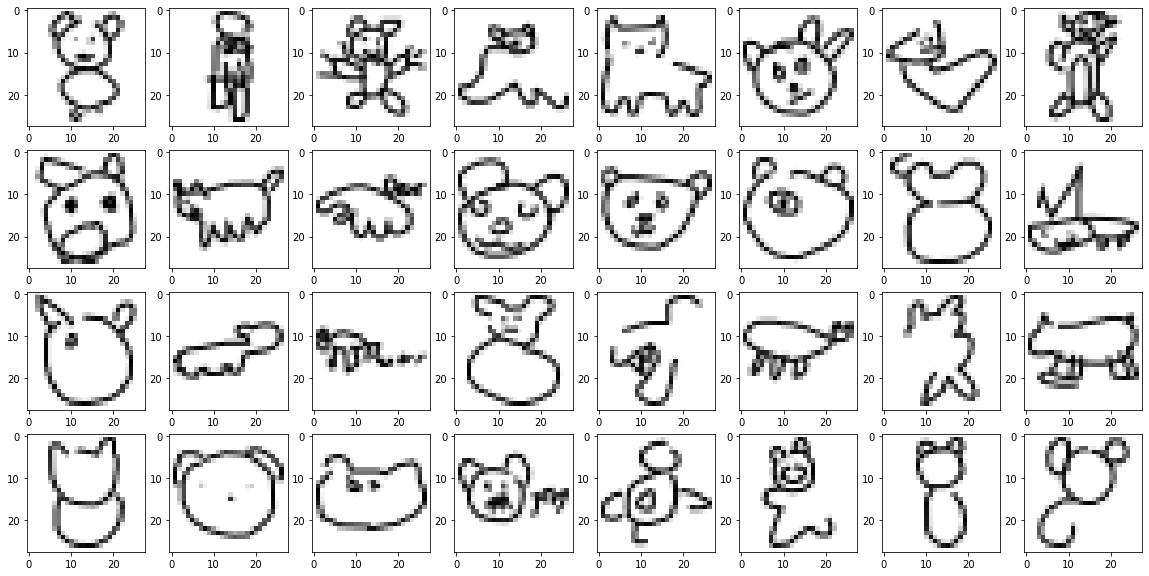

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(data_img['test'][i], cmap='binary_r')

plt.show()

In [26]:
import os
path_root = '/home/purewhite/workspace/cs420/project/data/dataset_processed_28/'

for file in os.listdir(path_root):
    tmp = file.replace('_', '.').split('.')
    os.rename(path_root+file, path_root+tmp[0]+'.'+tmp[-1])

In [29]:
import os
path_root = '/home/purewhite/workspace/cs420/project/data/dataset_raw/'

for file in os.listdir(path_root):
    tmp = file.replace('_', '.').split('.')
    # print(tmp)
    os.rename(path_root+file, path_root+tmp[-2]+'.'+tmp[-1])

---
# `paddingLength`

In [4]:
root = '/home/purewhite/workspace/cs420/project/data/dataset_raw/'

maxlen = 0
for filename in os.listdir(root):
    print(filename, end='\t')
    f = np.load(root+filename, allow_pickle=True, encoding='latin1')
    for k, v in f.items():
        for seq in v:
            maxlen = max(len(seq), maxlen)
    print(maxlen)

penguin.npz	115
115
115
rhinoceros.npz	120
120
120
pig.npz	151
151
151
camel.npz	151
151
151
horse.npz	155
155
155
whale.npz	155
155
155
raccoon.npz	205
205
205
zebra.npz	205
205
205
elephant.npz	205
205
205
dog.npz	205
205
205
crocodile.npz	205
205
205
bear.npz	205
205
205
monkey.npz	205
205
205
panda.npz	226
226
226
cat.npz	226
226
226
cow.npz	226
226
226
owl.npz	226
226
226
squirrel.npz	226
226
226
flamingo.npz	226
226
226
sheep.npz	226
226
226
hedgehog.npz	226
226
226
giraffe.npz	226
226
226
tiger.npz	226
226
226
lion.npz	226
226
226
kangaroo.npz	226
226
226
